# Population of Turkey's provinces
In this projest, population of 81 province in Turkey will be shown as Turkey's map. Chloropleth maps will be used.
- Population of each province will be taken from excel file.
- populations will be inserted into Turkey's geodataframe from Turkeys province shape file.
- Province names and populations will be placed on the map  

** To Do **  
-Bozuk il isimlerini lookup tablosundan değiştirmek / 20180726  
-Şehir merkezlerini nokta olarak haritaya işlemek / 20180727  
-Şehir isimlerini haritaya ekle  
-Groupby yıllara göre tabloyu düzenle  
-lejand da aralıkları belirleme

In [2]:
%matplotlib inline

import pandas as pd
import geopandas

# pd.options.display.max_rows = 10

## Maps and shape files


In [3]:
province_centers = geopandas.read_file("zip://./data/turkey-places-shape.zip", encoding = 'utf-8')
province_centers = province_centers.rename(columns={'name': 'province'})
province_centers = province_centers.loc[province_centers['type'] == 'city']
province_centers.head()

,osm_id,province,type,population,geometry
1,25869410,Ankara,city,0,POINT (32.8519769 39.9272322)
2,25869574,Edirne,city,0,POINT (26.5594881 41.6754293)
3,25869575,Çanakkale,city,0,POINT (26.4148869 40.1500808)
5,25869581,Tekirdağ,city,0,POINT (27.5098435 40.980083)
6,25869582,Balıkesir,city,0,POINT (27.8918468 39.6451957)


### province and towns shape files
gadm36_TUR_0.shp Turkey in general  
gadm36_TUR_0.shp Turkey/provinces  
gadm36_TUR_0.shp Turkey/towns  
shape files can be download at https://gadm.org/index.html 

In [4]:
provinces = geopandas.read_file("data/gadm36_TUR_1.shp", encoding = 'utf-8')
provinces = provinces[['NAME_1','geometry']]
provinces = provinces.rename(columns={'NAME_1': 'province'})

In [5]:
provinces.head()

,province,geometry
0,Adana,"(POLYGON ((35.20958328 36.67874908, 35.2095832..."
1,Adiyaman,"POLYGON ((38.68339157 37.60322571, 38.66181564..."
2,Afyon,"POLYGON ((30.18260765 37.90116119, 30.18877983..."
3,Agri,"POLYGON ((43.71635437 39.37020493, 43.7074585 ..."
4,Aksaray,"POLYGON ((34.39512634 38.19466782, 34.39625931..."


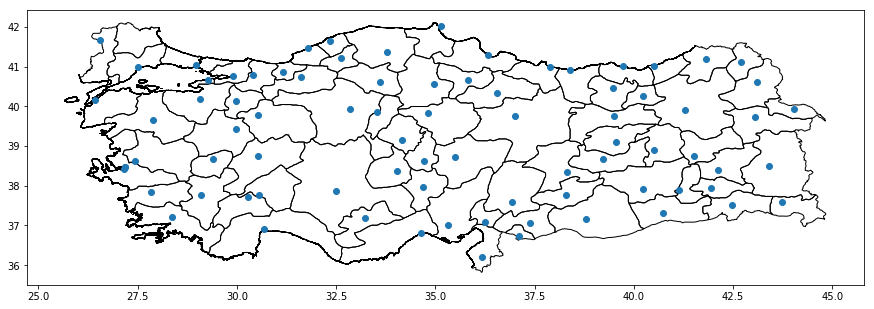

In [27]:
ax = provinces.plot(edgecolor='k', facecolor='none', figsize=(15, 15))
province_centers.plot(ax=ax)


Change coordinate system
CRS

## Load population from TUIK data
Read from csv file take from TUIK website https://biruni.tuik.gov.tr/medas/  
-skip 5 rows since they are scrambled from source

In [6]:
df = pd.read_csv("data/turkey_population.csv", sep='|', usecols=["year", "province", "population"]
                , index_col=False, header=None, skiprows=5, encoding = 'utf-8'
                , names=['year', 'province', 'population', 'value'])

There are NaN values on year column so it should ve filled with previous column.  
Last row is added from a empty line is csv so it should be removed

In [7]:
df=df.fillna(method='ffill') # fill NaN with previous row value
df=df[:-1] #remove last row

## Data clean up
- convert year and population to integer
- clean province text / split text for '-' and take the first element

In [8]:
df[['year','population']] = df[['year','population']].astype(int)
df['province']=df['province'].str.split('-',expand=True)[0]

Select year

In [9]:
df_year2017 = df.loc[df['year'] == 2017]
df_year2017.head()

,year,province,population
810,2017,Adana,2216475
811,2017,Adıyaman,615076
812,2017,Afyonkarahisar,715693
813,2017,Ağrı,536285
814,2017,Aksaray,402404


### replace wrong names  
data from shp file has wrong name, so it should be replaced before merged with population data  
data.replace({'very bad': 1, 'bad': 2, 'poor': 3, 'good': 4, 'very good': 5}, inplace=True)

In [10]:
wrong_provinces = pd.read_csv("data/wrong_provinces.csv", sep=',', header=None, index_col=False) # read two column into df
wrong_provinces_dic = dict(zip(wrong_provinces[0], wrong_provinces[1])) # convert df into dictionary
provinces.replace(wrong_provinces_dic, inplace=True) # replace wrong values

### Merge shp dataframe with population

In merge, first dataframe SHOULD BE geopandas dataframe os resulting merge will be a geopandas dataframe.

In [14]:
province_pop = pd.merge(provinces, df_year2017, on='province', how='outer')
province_pop.head()

,province,geometry,year,population
0,Adana,"(POLYGON ((35.20958328 36.67874908, 35.2095832...",2017,2216475
1,Adıyaman,"POLYGON ((38.68339157 37.60322571, 38.66181564...",2017,615076
2,Afyonkarahisar,"POLYGON ((30.18260765 37.90116119, 30.18877983...",2017,715693
3,Ağrı,"POLYGON ((43.71635437 39.37020493, 43.7074585 ...",2017,536285
4,Aksaray,"POLYGON ((34.39512634 38.19466782, 34.39625931...",2017,402404


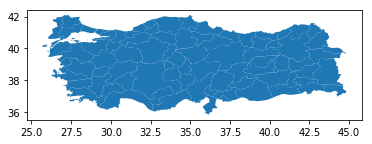

In [17]:
province_pop.plot()

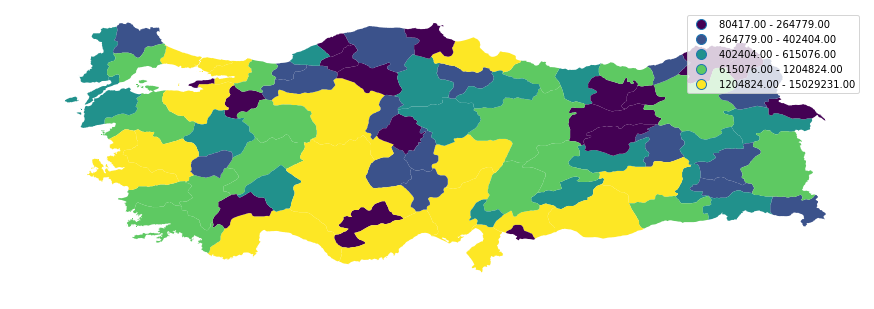

In [18]:
ax = province_pop.plot(figsize=(15, 15), column='population', scheme='quantiles', legend=True)
ax.set_axis_off()

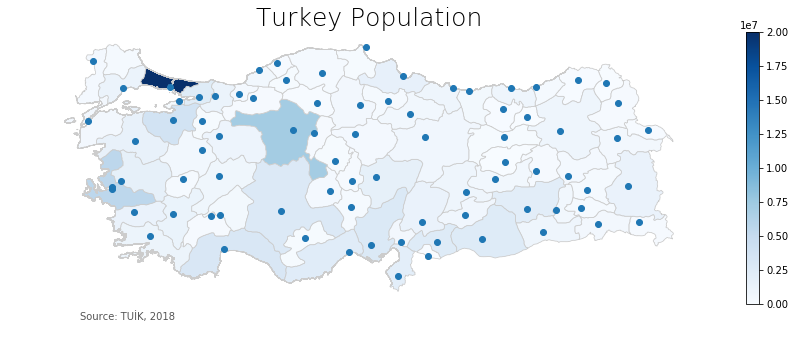

In [36]:
import matplotlib.pyplot as plt
# set a variable that will call whatever column we want to visualise on the map
variable = 'population'

# set the range for the choropleth
vmin, vmax = 0, 20000000

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 5))

# create map
province_pop.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
province_centers.plot(ax=ax)

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Turkey Population', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: TUİK, 2018',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('testmap.png', dpi=300)

## Analize Data

In [34]:
sum(province_pop['population']) #Turkey's population

80810525

In [20]:
province_rank = province_pop[province_pop['population']>1000000].sort_values(by='population', ascending=0) # provinces over 4 million people
province_rank['Rank'] = df['population'].rank(ascending=1)
province_rank.head()

,province,geometry,year,population,Rank
39,İstanbul,"(POLYGON ((29.11402893 40.82069397, 29.1140289...",2017,15029231,881.0
6,Ankara,"POLYGON ((33.74255371 39.11185455, 33.76644135...",2017,5445026,870.0
40,İzmir,"(POLYGON ((26.88152885 38.02430725, 26.8815288...",2017,4279677,859.0
20,Bursa,"(POLYGON ((28.53902626 40.56708145, 28.5390262...",2017,2936803,848.0
7,Antalya,"(POLYGON ((30.55347252 36.46097183, 30.5534725...",2017,2364396,801.0


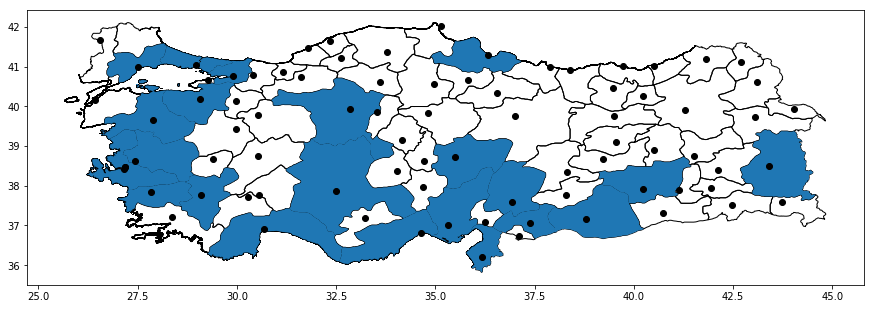

In [23]:
ax = provinces.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
province_rank.plot(ax=ax)
province_centers.plot(ax=ax, facecolor='k')

In [37]:
province_centers.to_csv("data/turkey_population_new.csv", encoding = 'utf-8')